# Correlation matrices visualization of CIFAR-100 models

In [ ]:
!export PYTHONPATH="/home/fabien/Documents/project/2d/mdistiller:$PYTHONPATH"

In [1]:
# !export PYTHONPATH="/home/fabien/Documents/project/2d/mdistiller:$PYTHONPATH"
# %env PYTHONPATH="/home/fabien/Documents/project/2d/mdistiller:$PYTHONPATH"
import sys
sys.path.append("/home/fabien/Documents/project/2d/mdistiller")
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
import seaborn as sns

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

In [2]:
def load_model(tea, stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    fully_state = load_checkpoint(mpath)["model"]
    student_weights = OrderedDict()
    teacher_weights = OrderedDict()

    for key, value in fully_state.items():
        # 检查权重键是否包含 "student"
        if 'student' in key:
            key = key.replace("module.student.", "")
            student_weights[key] = value
        if 'teacher' in key:
            key = key.replace("module.teacher.", "")
            teacher_weights[key] = value
    # model.load_state_dict(load_checkpoint(mpath)["model"])
    # tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    # tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    model.load_state_dict(student_weights)
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(teacher_weights)
    print("load {} successfully!".format(mpath))
    return model, tea_model, val_loader

In [3]:
# visualize the difference between the teacher's output logits and the student's
def get_output_metric(model, val_loader, num_classes=100):
    model.eval()
    feat = []
    label = []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            if i >= 10:
                break
            outputs, features = model(data)
            feat.append(features['pooled_feat'].data.cpu().numpy())
            label.append(labels.data.cpu().numpy())
            # all_feat.append(preds["feats"][-2].data.cpu().numpy())
            # all_labels.append(labels.data.cpu().numpy())
    all_features = np.concatenate(feat, 0)
    all_labels = np.concatenate(label, 0)
    return all_features, all_labels

def get_feat_output(tea, stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    # model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    # tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    model, tea_model, val_loader = load_model(tea, stu, mpath)
    print("load model successfully!")
    s_feat, s_label = get_output_metric(model, val_loader)
    t_feat, t_label = get_output_metric(tea_model, val_loader)
    return s_feat, s_label, t_feat, t_label, num_classes

def plot_features(features, labels, num_classes):
    colors = ['C' + str(i) for i in range(num_classes)]
    plt.figure(figsize=(6, 6))
    for l in range(num_classes):
        plt.scatter(
            features[labels == l, 0],
            features[labels == l, 1],
            c=colors[l], s=1, alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def get_tsne(tea, stu, mpath):
    s_feat, s_label, t_feat, t_label, num_classes = get_feat_output(tea, stu, mpath)
    tsne = TSNE()
    s_all_features = tsne.fit_transform(s_feat)
    plot_features(s_all_features, s_label, num_classes)
    t_all_features = tsne.fit_transform(t_feat)
    plot_features(t_all_features, t_label, num_classes)


In [4]:
from sklearn.manifold import TSNE
from sklearn import svm
from matplotlib.colors import ListedColormap

def visualize_decision_boundary(features, labels):
    """
    Visualize the decision boundary using t-SNE reduced features and labels.
    
    Parameters:
    - features: numpy array, shape (n_samples, n_features)
    - labels: numpy array, shape (n_samples,)
    """
    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    # Train a linear SVM for visualization
    clf = svm.SVC(kernel='linear')
    clf.fit(tsne_results, labels)
    
    # Create a mesh to plot the decision boundaries
    h = .02  # step size in the mesh
    x_min, x_max = tsne_results[:, 0].min() - 1, tsne_results[:, 0].max() + 1
    y_min, y_max = tsne_results[:, 1].min() - 1, tsne_results[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Plot the decision boundaries
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot also the training points
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title('Decision Boundary Visualization with t-SNE')
    plt.colorbar(scatter)
    plt.show()

In [5]:
mpath = "/home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best"
s_feat, s_label, t_feat, t_label, num_classes = get_feat_output("resnet32x4", "resnet8x4", mpath)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
load /home/fabien/Documents/project/2d/mdistiller/tools/output/final/324_84/fitnet_324_84/best successfully!
load model successfully!


10it [00:00, 12.07it/s]
10it [00:02,  3.46it/s]


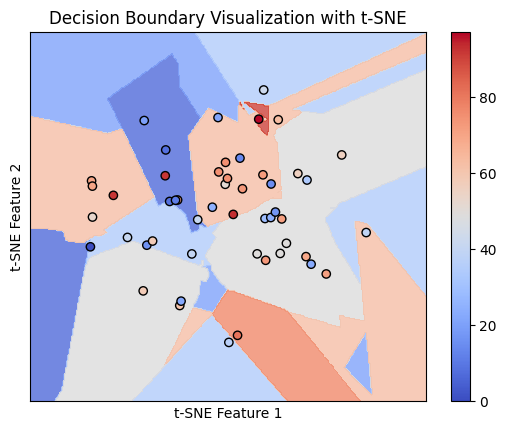

In [8]:
visualize_decision_boundary(s_feat[:50,], s_label[:50,])